--------------
--------------
# Introduction
--------------
--------------
In this notebook we present our study of the paper "PLANTED CLIQUE DETECTION BELOW THE NOISE FLOOR USING LOW-RANK SPARSE PCA" by Alexis B.Cook and Benjamin A.Miller.  

We will present the main problem tackled by the article, and we will try to reproduce some simulations from the paper, justify some formulations and passages, and numerically verify some anounced results.

## Problem
**Erdos Renyi Graph.** We recall that an Erdos Renyi graph $G(n,p)$ is a random undirected graph with $n$ vertices $\{v_1, \ldots, v_n\}$ and such that there is a link between each two vertices with a probability $p$.  

**Clique.** Given a graph $G=(V,E)$, a subset $V' \subset V$ is called a clique if all the elements of $V'$ are connected to each other. i.e
$$
\forall v_i, v_j \in V' \quad \{v_i, v_j\} \in E.
$$


**Planted Clique Problem.** We consider that we have an Erdos Renyi graph $G(n,p)$ with a planted clique $V^\star$ inside it. Our problem is to find this clique.

Many research teams took interest in this problem, and designed different algorithms to bring a solution for it. In particular, some of these algorithms use spectral methods analysing the adjascency matrix such graphs:
$$
A_{i j}=\left\{\begin{array}{ll}
1 & \text { if } v_{i}, v_{j} \in V^{*} \\
1 & \text { with prob } p \text { if } v_{i} \notin V^{*} \text { or } v_{j} \notin V^{*} \\
0 & \text { with prob } 1-p \text { if } v_{i} \notin V^{*} \text { or } v_{j} \notin V^{*}
\end{array}\right.
$$

Usually, the spectral methods use the modularity matrix $B$ defined for any $i,j \in \{1,\ldots, n\}$ by
$$
B_{ij} = A_{ij} - p
$$

## Plan
Our notebook will be organized as follows:  
* First we simply import some libraries and functions, then we implement some first elementary functions to be used later,
* We verify the Nadakuditi Theorem (3.1) via simulations, giving efficiency garantees for the Nadakuditi algorithm (not developped enough in the paper)
* Then we examine the limitations of this first algorithm and explain why the new algorithm of the paper is a better solution,
* After that we will prove the SDP formulation of the planted clique problem announced in the paper,
* Finally we reproduce some experiments to test the efficiency of the SPCA solution.

---------------------
---------------------
# Imports and Helpers
---------------------
---------------------

In [1]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D
import cvxpy as cvx
import numpy as np
import random
from scipy.stats import norm
import seaborn as sns
import sys
import pandas as pd

### Helpers

In [68]:
# Auxilary functions

# Law rank decomposition of a matrix
def lowrank_decompose(B,m):
    
    """ Compute B_m, low rank approximation B.

    Args:
        B (ndarray): symmetric matrix
        m (int): rank of decomposition

    Returns:
        B_1,B_2: decomposition s.t B_m = B_1.T @ B_2
    """
    
    eigvals, eigvecs = np.linalg.eigh(B)
    top_m = np.argsort(eigvals)[-m:] ##idx of top m eigvals
    B_1 = eigvecs[:,top_m] 
    B_2 = eigvals[top_m] * B_1
    
    return B_1, B_2

# DataFrame from discovery_rate matrix (to be seen later)
def table_to_df(n_vals, beta_vals, discovery_rate_table):
    """
    Objective: This function has for objective to better format the 
    discovery rate table in order to easily make plots using seaborn.
    -------------------------------------------------------------
    Input: list of values of n, list of values of beta, and a table with 
           the corresponding discovery rate of the hidden clique
    Output: An 
    """
    df2 = pd.DataFrame(columns=["n", "beta", "discovery_rate"])
    for i in range(len(beta_vals)) :
        for j in range(len(n_vals)) :
            elt = {"n": n_vals[j],
                "beta": beta_vals[i],
                "discovery_rate": discovery_rate_table[i,j]
            }
            df2 = df2.append(elt, ignore_index = True)
    return df2.pivot("beta", "n", "discovery_rate")


# Plotting functions
def plot_3D(X_reduced,y,
            fig,plot_name,
            pos,rstride, cstride,
            ):
    #To getter a better understanding of interaction of the dimensions
    # plot the first three PCA dimensions
    ax = fig.add_subplot(1, pos, 1, projection='3d')
    ax.scatter(
        X_reduced[:, 0],
        X_reduced[:, 1],
        X_reduced[:, 2],
        c=y,
        cmap=plt.cm.Set1,edgecolor="k",s=40,
        #rstride = rstride,cstride=cstride, 
    )
    ax.set_title(plot_name)
    ax.set_xlabel("1st eigenvector")
    ax.w_xaxis.set_ticklabels([])
    ax.set_ylabel("2nd eigenvector")
    ax.w_yaxis.set_ticklabels([])
    ax.set_zlabel("3rd eigenvector")
    ax.w_zaxis.set_ticklabels([])


def plot_embeds(X_pca,X_spca,y):
    # set up a figure twice as wide as it is tall
    #fig = plt.figure(figsize=plt.figaspect(0.20))
    fig = plt.figure(figsize=(25,5))
    plot_3D(X_spca,y,fig,"SPCA",2,10,10)
    plot_3D(X_pca,y,fig,"PCA",1,1,1)
    plt.show()
    

def plot_clique_embeds(x,clique_idx,ax=None,title=None):
    if ax is None: ax = plt.gca()
    ax.plot(abs(x),linestyle="",marker="o",label="embedding")
    true = np.zeros_like(x)
    true[clique_idx] = abs(x)[clique_idx]
    ax.plot(true,marker="x",color="red",label="true clique")
    ax.set_title(title)
    ax.legend()


### Cosnstruction of Erdos-Renyi Graphs, and Planted Clique Instances

In [69]:
# Constructing an Erdos-Renyi graph
def bernoulli(p):
    return np.random.binomial(1,p)

def random_sample(k,n):
    """
    samples k elements from {1,..,n}
    """
    l = [i for i in range(n)]
    return random.sample(l,k)

def bool_clique(clique, n):
    """
    returns a 0-1 vector of size n,
    where 1 coordinates indicate the elements of the clique
    """
    bclique = np.zeros(n, dtype=int)
    for j in clique :
        bclique[int(j)] = 1
    return bclique

def clique_from_bool(bool_clique):
    """
    Does the inverse operation of the previous function
    """
    clique = []
    for j in range(len(bool_clique)):
        if bool_clique[j]:
            clique.append(j)
    return np.array(clique)


def planted_clique(n,k,p):
    """
    Creates an input of the planted clique
    with parameters n,k,p
    Output: the adjascency matrix of the graph,
            a list indicating the indices of the clique elements
    """
    A = np.zeros((n,n), dtype=int)
    for i in range(n) :
        for j in range(i) :
            A[i,j] = bernoulli(p)
            A[j,i] = A[i,j]
    clique = random_sample(k,n)
    for i in clique :
        for j in clique :
            if i!=j :
                A[i,j] = 1
                A[j,i] = 1
    return A, bool_clique(clique,n)

---------------------
---------------------
# Nadakuditi Algorithm
----------------------
----------------------

Given the adjacency matrix $A$ of an Erdos Renyi graph $G(n,p)$ with a planted clique and a parameter $\alpha \in (0,1)$, we will write the Nadakuditi algorithm returning the set
$$
    \hat{V}^{*}=\left\{v_{i}:\left|\sqrt{n} u_{i 1}\right|>F_{N(0,1)}^{-1}\left(1-\frac{\alpha}{2}\right)\right\}
$$
Where $u_{i1}$ are the coordinates of the principal eigen vector of the modularity matrix ($B_{ij} := A_{ij} - p$).

**Theorem 3.1** ensures that the set $\hat{V}^{*}$ is (asymptotically) with high probability the planted clique $V^{*}$ we are looking for, from the moment that
$$
k \approx \beta \sqrt{n} 
\qquad \text{ with } \qquad
\beta > \sqrt{\frac{p}{1-p}}
$$

More precisely, it states that for an instance $n,k,p$ of the planted clique, and for any choice of $\alpha \in (0,1)$ and $\beta>0$, if $k \approx \beta \sqrt{n}$
$$
\mathbb{P}(\text { clique discovered }) \stackrel{\text { a.s. }}{\longrightarrow}\left\{\begin{array}{ll}
1 & \text { if } \beta>\beta_{\text {crit. }}:=\sqrt{\frac{p}{1-p}} \\
\alpha & \text { otherwise. }
\end{array}\right.
$$

## Implementation
Let us first implement the algorithm.

In [5]:
# Implementation of the algorithm

def compute_principal(X) :
    """
    Input: a matrix X
    Output: Principal eigenvector
    """
    eigvals, eigvecs = np.linalg.eigh(X)
    return eigvecs[:,np.argmax(eigvals)]

def get_clique_nadak(B, alpha):
    """
    Input: the modularity matrix B, the parameter alpha
    Output: The set V given by the Nadakuditi algorithm
    """
    u1 = compute_principal(B)
    n = B.shape[0]
    thresh = norm.ppf(1-alpha/2)
    V = np.abs(np.sqrt(n)*u1) > thresh
    return V


## Test

Now in order to verify the claim of the theorem, we need to fix a value of $\beta$ and then for each value of $n$ run the algorithm multiple times and count the number of sucesses. This will give an estimation of the probability of discovering the hidden clique.

In [6]:
# Test functions

def test_clique_discovery(n, k, p=0.2, alpha=0.05) :
    """
    Creates an Erdos Renyi graph of size n with a planted clique of size k,
    uses Nadakuditi algorithm to find the clique
    returns True if the clique is discovered and false otherwise
    """
    # Constructing the Erdos-Renyi graph
    A, clique = planted_clique(n,k,p)
    B = A - p
    # Nadakuditi algorithm
    V = get_clique_nadak(B, alpha)
    # Compare V to the planted clique
    return (V==clique).all()
    

def test_theorem_nadak(p, beta, alpha, n_step, num_tests=20, itermax=50, track=True):
    """
    Input: p, beta (k=beta*sqrt(n)), alpha as in Nadakuditi algorithm
           n_step = the step between the different values of n
           num_tests = number of tests for each value of n (on which we average)
           itermax = maximum number number of iterations
    Output: a list, where each value gives the discovery rate of the hidden clique 
            for the corresponding value of n and k=beta*sqrt(n)
    """
    # List of the values of n
    n_values = [i*n_step for i in range(1,itermax+1)]
    discovery_rate = np.zeros(itermax)
    # Computing the discovery rates
    for i in range(itermax):
        # Track the iteration
        if track and i%10 == 0:
            print(" - iteration num ", i, "...")
        n = n_values[i]
        k = min(n, int(beta*np.sqrt(n)))
        count_success = 0
        # Count the succesful clique discoveries over num_tests times
        for j in range(num_tests):
            count_success += test_clique_discovery(n, k, p, alpha)
        # Store the result in the array discovery_rate
        discovery_rate[i] = count_success/num_tests
        # If the last l rates are =1, we accept that we reached the convergence
        l = 10
        if i>l and discovery_rate[i-l+1:i+1].sum() == l :
            discovery_rate[i+1:] += 1
            break
    return discovery_rate

Let us run a first test with the setting
* $p=0.2$
* $\beta = 2$
* $\alpha = 0.05$  

Observe that the critival value of $\beta$ for $p=0.2$ is $\beta_{\text{critic}} = 0.5$ 

 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...


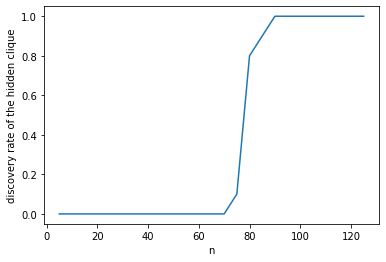

In [9]:
p = 0.2 #beta_critic = 0.5
beta = 2
alpha = 0.05

n_step = 5
num_tests = 10
itermax = 25


discovery_rate = test_theorem_nadak(p, beta, alpha, n_step, num_tests, itermax)

n_vals = np.array([i*n_step for i in range(1,itermax+1)], dtype=int)

plt.xlabel("n")
plt.ylabel("discovery rate of the hidden clique")
plt.plot(n_vals, discovery_rate)

This plot may give us some first ideas about the convergence of Nadakuditi algorithm
* The algorithm converges for relatively small values of $n$
* The maximal discovery rate 1 is really reached: it is not only an asymptotic value unreachable in practice!
* When variying $n$ we can distinguish three regimes, a first regime where the clique is never discovered, then a very short regime where the discovery probability goes from 0 to 1, and then a regime where the clique is always discovered.

In order to confirm these observations, we will test the convergence for different values of $\beta$. In particular, we will see how the "threshold" value of $n$ (defining the second regime) depends on $\beta$ when the other parameters are fixed.

## $\beta$ and the threshold value of $n$

In the following, we fix $\alpha=0.05$, and we will try two different values of $p$:  
* $p=0.2$ for which $\beta_{crit} = 0.5$  
* $p=0.5$ for which $\beta_{crit} = 1$  

For each $p$ we will vary $\beta$ from 0.5 to 4 (with step 0.1), and for each value of $\beta$ we vary $n$ from 5 to 250 (with step 5).
For each setting, the discovery rate of the hidden clique is computed over 50 tests.

WARNING: The following cells take too long to run!! ($\approx$ 3 hours each).  
You can use the previous cell to choose a particular value of $\beta$ and see how the discovery rate converges.

In [5]:
# WARNING: approximatively 200 min (3h20min) to run
n_step = 5
p = 0.2
alpha = 0.05
num_tests = 50
itermax = 50

beta_vals = [0.5 + 0.1*i for i in range(35)]

discovery_rate_table = np.zeros((len(beta_vals), itermax))

for i in range(len(beta_vals)):
    beta = beta_vals[i]
    print("beta = ", beta)
    discovery_rate_table[i] = test_theorem_nadak(p, beta, alpha, n_step, num_tests, itermax, track=False)

beta =  0.5
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  0.6
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  0.7
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  0.8
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  0.9
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  1.0
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  1.1
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  1.2000000000000002
 - iteration num  0 .

In [6]:
# Save the output to a csv file
pd.DataFrame(discovery_rate_table).to_csv("discovery_rate_p02.csv", header=None, index=None)

In [15]:
# WARNING: approximatively 200 min (3h20min) to run
n_step = 5
p = 0.4
alpha = 0.05
num_tests = 50
itermax = 50

beta_vals = [0.5 + 0.1*i for i in range(35)]

discovery_rate_table2 = np.zeros((len(beta_vals), itermax))

for i in range(len(beta_vals)):
    beta = beta_vals[i]
    print("beta = ", beta)
    #discovery_rate_table[i] = test_theorem_nadak2(p, beta, alpha, n_step, num_tests, itermax, i)
    discovery_rate_table2[i] = test_theorem_nadak(p, beta, alpha, n_step, num_tests, itermax)

beta =  0.5
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  0.6
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  0.7
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  0.8
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  0.9
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  1.0
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  1.1
 - iteration num  0 ...
 - iteration num  10 ...
 - iteration num  20 ...
 - iteration num  30 ...
 - iteration num  40 ...
beta =  1.2000000000000002
 - iteration num  0 .

In [9]:
# Save the output to a csv file
pd.DataFrame(discovery_rate_table2).to_csv("discovery_rate_p04.csv", header=None, index=None)

<AxesSubplot:title={'center':'p=0.4'}, xlabel='n', ylabel='beta'>

<Figure size 720x576 with 0 Axes>

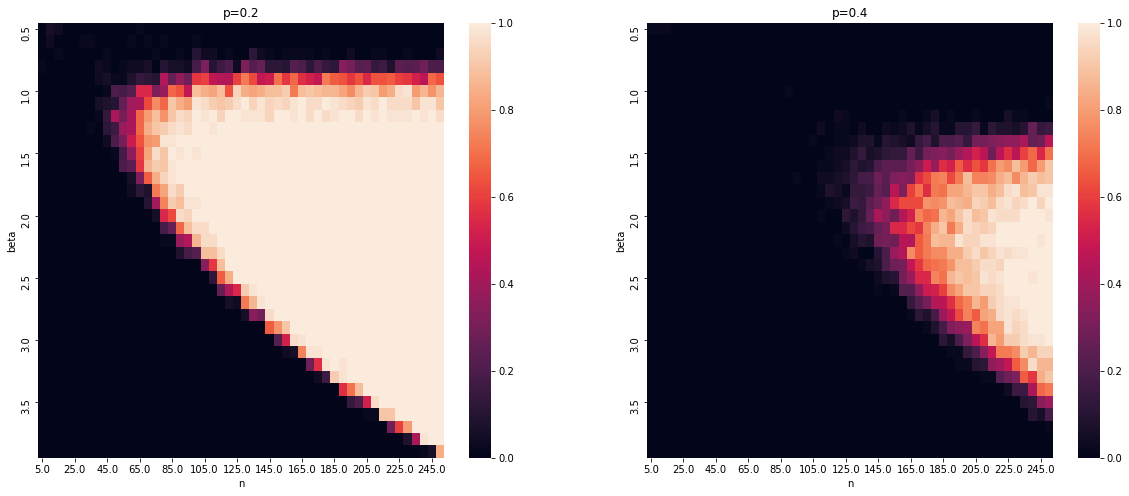

In [61]:
figure(figsize=(10, 8))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

n_vals = np.array([i*n_step for i in range(1,itermax+1)], dtype=int)
df1 = table_to_df(n_vals, beta_vals, discovery_rate_table)
df2 = table_to_df(n_vals, beta_vals, discovery_rate_table2)


ax1.set_title("p=0.2")
ax2.set_title("p=0.4")
sns.heatmap(df1, xticklabels=4, yticklabels=5, ax=ax1)
sns.heatmap(df2, xticklabels=4, yticklabels=5, ax=ax2)

In these two figures, corresponding respectively to $p=0.2$ and $p=0.4$, we illustrate the convergence of the discovery probability for different values of $\beta$.  

Let us focus for now on the first figure ($p=0.2$). Each "row" corresponds to a given value of $\beta$, and shows how the discovery probability varies when varying $n$.

We observe that when $\beta$ gets close to the critical value $\beta_{crit} = 0.5$, the discovery probability does not grow fasly and converge to 1. Theoretically, for all values of $\beta > 0.5$ we should have convergence, but our simulation shows at least that the convergence for values close to $0.5$ is hard and not reached for small values of $n$. 

However, for $\beta$ far enough from the critical value, we see that the algorithm is very efficient even for small values of $n$. Moreover, we observe again the three regimes we discussed earlier: For each value of $\beta$
* First regime: small values of $n$, the clique is never discovered,  
* Second regime: a very short regime, where the discovery probability goes from 0 to 1,  
* Third regime: $n$ large enough, the clique is always discovered.  

The very surprising fact is how short is the second regime: the discovery probability goes from 0 to 1 within less 20 values of $n$! 
Another surprising observation is that the value 1 is reached the earlier for $\beta \approx 1.5$, while we were expecting that the farther we are from $\beta_{crit}$ the faster is the convergence. It seems that the "threshold" value of $n$ is increasing with $\beta$.

For $p=0.4$, it seems that the same phenomenons are happening, but observing them will require larger values of $n$ and $\beta$, which is normal because $\beta_{crit}$ is larger for $p=0.4$.  


Unfortunately, the paper proving Nadakuditi theorem is not a public paper, thus we were not able to examine the proof and better understand the reasons behind these observations.

## Limitation

The principal limitation of Nadukiditi algorithm is, as pointed in the article and as we verified in our simulations, that is performs very poorly when $\beta < \beta_{crit}$. This is why the article presents a different PCA method to overcome this.

---------------------
---------------------
# Sparse Principal Component Analysis :
---------------------
---------------------

## Justification of the DSCPA formulation : 


In this section, we detail the computations to prove the SDP relaxation of the SPCA problem which the authors call Direct SPCA. 


### Primal \& Dual : 
\begin{array}{ c c l }
Primal\ : & \max_{x\in \mathbb{R}^{n}} & x^{T} Ax\\
 & subject\ to & \ \Vert x\Vert _{2}^{2} =1
\end{array}

\begin{array}{l}
\begin{aligned}
\mathcal{L}( x,u) & =\ x^{T}( A-u.I_{n}) x\ +\ u\\
\theta ( u) & =sup_{x}\mathcal{L}( x,u)\\
 & =\ 
 \begin{cases}
    +\infty \  & \ if\ A-u.I_{n} \ \in S_{n}^{++}\\
    u\ \ \  & else
\end{cases}
\end{aligned} \ \ \\
\\
\end{array}


\begin{array}{ c c l c c }
Dual: & min_{u\in \mathbb{R}} & u= \lambda ^{max}( A)&\\
 & subject\ to & A-u.I_{n} \ \in S_{n}^{-} &  & 
\end{array}

There is no equality constraints on the primal, slater conditions apply and duality gap is zero.
### Lagrangian of the dual 

We can rewrite the dual by adding a slack variable $v$ : 

\begin{array}{ c l l }
Dual\ :\  & min_{u\in \mathbb{R}}{} & u\\
 & s.t & g( u) \ \in \ K:=\ S_{n}^{-} \ \\
 &  & \\
= & min_{u,v\in \mathbb{R} ²}{} & u\\
 & s.t & v\ \in \ K\ \\
 &  & g( u) =v\\
 &  & 
\end{array}\\

With this formulation, the support function appears in the dual:

\begin{aligned}

    \begin{aligned}
        \tilde{\mathcal{L}}( u,v,X)
    \end{aligned}

    & =\ u\ +\ < X,g( u) -v >\\

    \tilde{\theta }( X) & =\ \inf_{u,v}\tilde{\mathcal{L}}( u,v,X)\\
    & =\ \inf_{u}\inf_{v\in K} \ ( u\ +\ < X,g( u)  >\ -< X,v >)\\
    & =\ \inf_{u} \ \ u\ +\ < X,g( u)  >\ +\ \inf_{v\in K} \ -< X,v >\\
    & =\ \inf_{u} \ \mathcal{L}( u,X) \ -\ \sigma _{K}( X) \ ( **)
\end{aligned}\\

(**) Recall the property of a support function over a convex cone $K$: 
\begin{aligned}
\sigma _{K}( X)  :\  & =\ 
\begin{cases}
0 & if\ X\ \in \tilde{K} \ :=\{U\ :\ < U,Y >\ \leq 0\ \ \forall Y\ \in K\}\\
+\ \infty  & else
\end{cases}
\end{aligned}
 ### Dual of the dual (Lifting): 
 
One can prove that $\widetilde{S_{n}^{-}} =S_{n}^{+} $ allowing to rewrite the lagrangian as :

\begin{array}{l}

\begin{aligned}
\tilde{\theta }( X) & =\ \inf_{u} \ u\ +\ < X,A-u.I_{n}  >\\
 & =\ < X,A >+\ \ \inf_{u} \ u\ ( \ 1\ -\ < X,I_{n}  >)\\
 & =\ Tr( X A) +\ \ \inf_{u} \ u\ ( \ 1\ -\ Tr( X)) \ \ \ \ \ \left[ *:\ X\ =\ X^{T}\right]\\
 & =\ 
    \begin{cases}
        0 & if\ Tr( X) \ \leq \ 1\\
        -\ \infty  & else
    \end{cases}
\end{aligned}
\end{array}



\begin{array}{ c c l }
\begin{aligned}
Lifting:  & 
\end{aligned} \  & max_{X} & Tr( XA)\\
 & subject\ to & X\ \succsim \ 0\\
 &  & Tr( X) \ =1\ ( **)
\end{array}\\


(**) We can show that the trace inequality is in fact an equality.

Indeed, if $X^*$ is a solution of L such that $Tr(X^*) \ =\alpha < \ 1$

Then $\tilde{X} \ =\ \frac{1}{\alpha } \ X^*$ is a valid point and $Tr\left(\tilde{X} A\right) \ =\ \frac{1}{\alpha } \ Tr(X^* A) \  >Tr(X^* A)$.


By taking $u = \lambda ^{max}( A) + 1 $ we have that $A-u.I_{n} \ \in S_{n}^{--}$ 

The conic slater conditions hold for the dual problem thus the duality gap between Dual and Lifting is zero.
### Simplify Lifting : 

Denote by val = value(L) = value (P): 
\begin{array}{l}
\\
\exists x^{*} \ \in \mathbb{R}^{n} \ s.t\ \left\Vert x^{*}\right\Vert _{2}^{2} =1\ \ and\ < x^{*} ,Ax^{*}  >\ =\ val\\
\Longrightarrow \exists x^{*} ,\ s.t\ \ Tr\left( x^{*} x{^{*}}^{T}\right) \ =\ 1,\ \ \ < x^{*} x{^{*}}^{T} ,A >\ =\ val\\
\Longrightarrow \ \exists X^{*} =x^{*} x{^{*}}^{T} \ \ s.t,\ X^{*} \ \succsim \ 0,\ Tr\left( X^{*}\right) \ =1\ ,Rank\left( X^{*}\right) \ =\ 1\ \ and\ X^{*} \ solution\ of\ DD.\\

\end{array}

Thus the search space of L can be further simplified : 

\begin{array}{ l l l }
L\ :\  & max_{X} & Tr( XA)\\
 & subject\ to & X\ \succsim \ 0\\
 &  & Tr( X) \ =1\\
 &  & Rank( X) =1
\end{array}\\



The cardinality constraint is an integer constraint it can be relaxed.

We also drop the rank constriant we will justify later.

 \begin{array}{l}
\begin{array}{ c c l }
\begin{aligned}
SCPA\  & :
\end{aligned} \  & max_{X} & Tr( XA) \ -\ \rho \ \mathbb{1}^{T} |X|\mathbb{1}\\
 & subject\ to & X\ \succsim \ 0\\
 &  & Tr( X) \ =1
\end{array}\\
\end{array}


We rewrite the penalty as an optimization problem.

\begin{array}{l}
\begin{aligned}
-\rho \ \mathbb{1}^{T} |X|\mathbb{1} \  & = & -\rho \sum _{i,j} |X_{ij} | & = & min_{U}\sum _{i,j} U_{ij} X_{ij} \  & = & min_{U} Tr( XU)\\
 &  &  &  & s.t\ |U_{ij} |\ \leqslant \ \rho  &  & \ \ s.t\ |U_{ij} |\ \leqslant \ \rho 
\end{aligned}
\end{array}

We can see a maxmin form of SCPA : 

 \begin{array}{l}
\begin{array}{ c c c c }
 & \max_{X} \ \ \min_{U} & \ \ \mathbf{Tr} \ ( X( A+U)) & \\
 & X\ \succsim \ 0,Tr( X) \ =1 &  & \\
 & \ |U_{ij} |\ \leqslant \ \rho  &  & 
\end{array}\\
\end{array}

Its dual is the minmax : 

\begin{array}{ c c c c }
\min_{U} & \ \max_{X} \ \ \ \mathbf{Tr} \ ( X( A+U)) & = & \min_{U} \ \mathbf{\lambda }^{max}( A+U)\\
\ |U_{ij} |\ \leqslant \ \rho  & X\ \succsim \ 0,Tr( X) \ =1 &  & \ |U_{ij} |\ \leqslant \ \rho \\
 &  &  & 
\end{array}
### Justification for rank constraint : 


In the maxmin formulation, by taking $X = \frac{1}{N}I_N$ we get the conic slater conditions and both problems are equivalent.

Thus, by applying KKT conditions to the primal and dual we get : 



The KKT conditions can be further simplified: 

\begin{cases}
X^{*} \ maximizes\ \mathcal{L}\left( .,U^{*}\right) :\  & ( A+U) \ X\ =\ \mathbf{\lambda }^{max}\left( A+U^{*}\right) X\ \ \ \ ( **)\\
Complementary\ slackness:\  & \ X^{*} \ \odot \ U^{*} \thinspace =\ |\ X^{*} |\\
Primal\ feasible\ :\  & X^{*} \ \succsim \ 0,Tr\left( X^{*}\right) \ =1\\
Dual\ feasible\ :\  & \ |U_{ij}^{*} |\ \leqslant \ \rho \ \ \ 
\end{cases}




\begin{array}{l}
\mathbf{(**) \ :\ Tr} \ \left( X^{*}\left( A+U^{*}\right)\right) \ \underset{Von-Neumann}{\leq } \ \sum _{i} \sigma _{i}\left( X^{*}\right) \sigma _{i}\left( A+U^{*}\right) \ \\
\leq \ \sum _{i} \sigma _{i}\left( X^{*}\right) \ \mathbf{\lambda }^{max}\left( A+U^{*}\right) \ \underset{\sum _{i} \sigma _{i}\left( X^{*}\right) =1}{\leq } \ \mathbf{\lambda }^{max}\left( A+U^{*}\right)
\end{array}

We are dealing with covariance matrices of random data, thus one can suppose that the eigenvalue $\lambda^{max}(A+U)$ is simple (b).

In this case, we get equality iff :

$$\sigma _{1}\left( X^{*}\right) \ =1\ \ and\ \sigma _{i}\left( X^{*}\right) =0\ \forall i\neq 1\Longrightarrow \ Rank\left( X^{*}\right) \ =\ 1.$$

 \begin{array}{l}
\sigma _{1}\left( X^{*}\right) \ =1\ \ and\ \sigma _{i}\left( X^{*}\right) =0\ \forall i\neq 1\Longrightarrow \ Rank\left( X^{*}\right) \ =\ 1\\
\Longrightarrow \ \exists x^{*} \in \mathbb{R}^{n} \ such\ that\ \ X^{*} \ =\ x^{*} x{^{*}}^{T} \ \ ( c)\\
\\
( a) \ +( b) +( c) :\ 
\begin{drcases}
< \left( A+U^{*}\right) x^{*} ,x^{*}  >\ =\ \mathbf{\lambda }^{max}\left( A+U^{*}\right)\\
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \left\Vert x^{*}\right\Vert _{2}^{2} \ =1\ \ \\
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \mathbf{\lambda }^{max} \ is\ simple\ 
\end{drcases} \ \ \\
\\
\Longrightarrow \ x^{*} \ is\ the\ principal\ component\ of\ \left( A+U^{*}\right) \ =\ v^{max} \ \left( A+U^{*}\right) \ \\
\Longrightarrow \ \left( A+U^{*}\right) X^{*} \ =\ \left( A+U^{*}\right) x^{*} x{^{*}}^{T} =\ \mathbf{\lambda }^{max}\left( A+U^{*}\right) x^{*} x{^{*}}^{T} \ =\ \mathbf{\lambda }^{max}\left( A+U^{*}\right) X^{*}\\
\end{array}

## Implementation of DSPCA : 

We solve the optimization problem using CVXPY, a modeler that uses very pythonesque syntax.

CVXPY uses SCS conic program solver by default for the SDP.

In [11]:
def project_spca(n_components,A,s):
    """  Projects matrix A into the subspace spanned by the DSCPA.
    
    Returns:
        ndarray: Matrix A projected into the DSCPA direction.
    """
    C = np.cov(A,rowvar=False)     
    spca = compute_pca_directions(C,n_components,s)
    A_reduced =  A @ spca
    return A_reduced
    
    
def compute_pca_directions(C,n_components,s,m=None):

    
    """
    Compute n_components of DSCPA decomposition.
    Each component spans at most k dimensions.
    
    Args:
        C (ndarray): Covariance matrix : MUST BE SYMMETRICAL !!
        n_components (int): number of computed directions.
        s (int): number of components in each direction.
        m (optional:int) rank of the lowrank approximation of C

    Returns:
        ndarray: the directions of PCA
    """
    
    rslt = np.zeros((C.shape[0],n_components))
    for i in range(n_components):
        value,sol = solve_sdp(C,s,m)
        eigvals, eigvecs = np.linalg.eigh(sol)
        x = eigvecs[:,np.argmax(eigvals)].reshape(-1,1)  ## x such that  X = x@x.T
        rslt[:,i] = x.squeeze()
        C = C - value * sol   
    return rslt
 
def solve_sdp(C, s,m=None):
    
    """
    Compute a solution the s-sparse PCA of A.
    if m is provided a lowrank approximation of A is used.

    Args:
        A (ndarray): Matrix to extract the sub-matrix from
        s (int): Sparsity level for the lower bound.
        m (optional:int) rank of the lowrank approximation of C

    Returns:
        (int,ndarray): value and optimal point
    """

    n_dim = C.shape[0]
   
    X = cvx.Variable((n_dim, n_dim),symmetric=True)
    
    if m is None:
        objective = cvx.Maximize(cvx.trace(C@X))
    else : 
        C_1,C_2 = lowrank_decompose(C,m)
        objective = cvx.Maximize(cvx.trace(C_1.T @ X @ C_2))
        
    pb = cvx.Problem(objective,
                     [X >> 0, ## X positive semidefinite
                     cvx.trace(X) - 1 == 0,
                     cvx.sum(cvx.abs(X))-s <= 0 
                     ])   
    pb.solve(verbose=False, max_iters=10000)
    return pb.value,X.value

## DSPCA in practice :

Before digging into the planted clique solution, let us see how the SPCA compares to the normal PCA.

Here we plot the 3D embedding of the iris dataset for both PCA and Sparse PCA formulation.

The resulting embeddings are comparable visually.

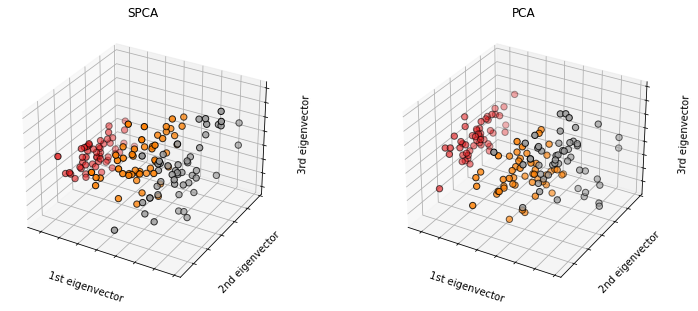

In [12]:
iris = datasets.load_iris()
X = iris.data 
X = X - np.mean(X , axis = 0) 
y = iris.target

X_pca  = PCA(n_components=3).fit_transform(X)
X_spca = project_spca(n_components=3,A=X,s=3)
plot_embeds(X_pca,X_spca,y)

--------------------------
--------------------------
# K-clique detection + SPCA : 
--------------------------
--------------------------

Here we plot the components of $b_{pca}$ the principal vector of B and $b_{spca}$ it's k-sparse principal vector. We see that for the sparse vector,even in extreme cases of large $p$, the entries for the planted clique are larger than the rest of the points of the graph. A simple thresholding algorithm would suffise to have a decent detector of the clqiue.

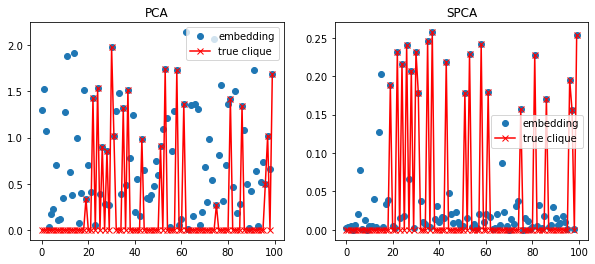

In [71]:
n,k,p = 100,20,0.6

Adj,bool_clique = planted_clique(n,k,p)
clique_idx = clique_from_bool(bool_clique)
B = Adj - p * np.ones_like(Adj)

b_spca = compute_pca_directions(B,n_components=1,s=k)
b_pca  = PCA(n_components=1).fit_transform(B)

fig,axs = plt.subplots(1,2,figsize=(10,4))
plot_clique_embeds(b_pca,clique_idx,axs[0],"PCA")
plot_clique_embeds(b_spca,clique_idx,axs[1],"SPCA")

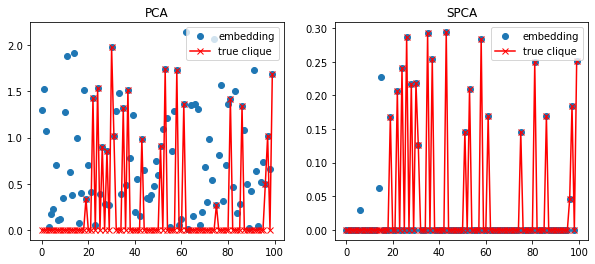

In [72]:
m = k
b_spca = compute_pca_directions(B,n_components=1,s=k,m=m)

fig,axs = plt.subplots(1,2,figsize=(10,4))
plot_clique_embeds(b_pca,clique_idx,axs[0],"PCA")
plot_clique_embeds(b_spca,clique_idx,axs[1],"SPCA")

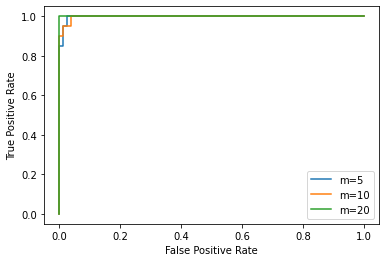

In [63]:
def plot_roc(B,k, clique_idx):
    
    ms = [5,10,20]
    clique_tgts = np.zeros(B.shape[0])
    clique_tgts[clique_idx] = 1
    
    for m in ms : 
        
        b_spca = compute_pca_directions(B,n_components=1,s=k,m=m)
        fpr, tpr, _  = roc_curve(clique_tgts,np.abs(b_spca))
        plt.plot(fpr,tpr,label="m="+str(m))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

plot_roc(B,k, clique_idx)

## Why SPCA works on clique detection :  

In the section 4 of the paper, the authors give some theoretical efficiency guarantees on their algorithm.   
That section used many advanced results from many other papers. Even though the computations made were easy to follow, it was not clear how some approximations can be justified.

We recall that the planted clique is $V^\star$, the adjacency matrix of the graph verifies
$$
A_{i j}=\left\{\begin{array}{ll}
1 & \text { if } v_{i}, v_{j} \in V^{*} \\
1 & \text { with prob } p \text { if } v_{i} \notin V^{*} \text { or } v_{j} \notin V^{*} \\
0 & \text { with prob } 1-p \text { if } v_{i} \notin V^{*} \text { or } v_{j} \notin V^{*}
\end{array}\right.
$$
and the modularity matrix is defined by $ B_{ij} = A_{ij} - p $.

A firt statement is that we can approximate $B$ by a matrix of the form$ X+P $, where
* $X$ is a symmetric matrix such that $X_{ij} + p \sim \text{Bernoulli}(p)$,
* $P$ a 1-rank matrix of the form $P = \theta u^T u$, with $\theta = k(1-p)$ and $u_i = \frac{1}{\sqrt{k}} 1_{v_i \in V^\star}$.

To better understand this approximation, let us see the probability distribution of the entries of the matrix $\hat{B} := X +P$.  
For any $i,j$ let us denote $e_{ij} := X_{ij} + p \sim \text{Bernoulli}(p)$. Wr have
$$
\begin{align*}
    \hat{A}_{ij}  &:= \hat{B}_{ij} + p \\
                  &= X_{ij} + p + k(1-p) u_i u_j\\
                  &= X_{ij} + p + (1-p)1_{v_i, v_j \in V^\star}\\
    \hat{A}_{ij}  &= \left\{\begin{array}{ll}
                        1 + X_{ij} & \text { if } v_{i}, v_{j} \in V^{*} \\
                        1 & \text { with prob } p \text { if } v_{i} \notin V^{*} \text { or } v_{j} \notin V^{*} \\
                        0 & \text { with prob } 1-p \text { if } v_{i} \notin V^{*} \text { or } v_{j} \notin V^{*}
                     \end{array}\right.
\end{align*}
$$

The distribution of $\hat{A}_{ij}$ is almost the same as $A_{ij}$, the difference is that $\hat{A}_{ij}$ contains an additional noise $X_{ij}$ in the case where $v_{i}, v_{j} \in V^{*}$ such that $\mathbb{E}[X_{ij}] = 0$.  

Since $X$ is a symmetrix real matrix, it can be diagnolized in an orthonormal basis:

$$ X = U_X^T D U_X$$

and thus we have

$$
\hat{B} = U_X^T (D + \theta \tilde{u}^T \tilde{u}) U_X
$$
where $\tilde{u} := U_X^T u$. What the authors prove is that a "lot of the information on $\tilde{u}$ is contained in the $m$ dimentional eigenvector space of $B$" i.e we fix $m \leq n$ and we try to find a lower bound for $\| U^{*T} \tilde{u} \|$ where $U^*$ is the solution for
$$
U^{*}=\underset{U \in \mathcal{U}_{m}}{\arg \max } \operatorname{tr}\left(U^{T}\left(D+\theta \tilde{u} \tilde{u}^{T}\right) U\right)
$$
with $\mathcal{U}_{m}$ the set of $n\times m$ matrices with orthonormal columns.   

Now to find a good lower bound we define for any vector $v \in \mathbb{R}^{n - (m-1)}$ the matrix 
$$
V_{m}=\left[\begin{array}{cc}
I_{m-1} & 0_{m-1,1} \\
0_{n-(m-1), m-1} & v
\end{array}\right]
\in \mathcal{U}_{m},
$$
By definition of $U^*$ we immediately have that 
$$
\operatorname{tr}\left(U^{* T}\left(D+\theta \tilde{u} \tilde{u}^{T}\right) U^{*}\right) \geq \max _{v} \operatorname{tr}\left(V_{m}^{T}\left(D+\theta \tilde{u} \tilde{u}^{T}\right) V_{m}\right)
$$
By further computations we have also that $\| V_m^{T} \tilde{u} \|$ is a lower bound for $\| U^{*T} \tilde{u} \|$.  
Finally, assuming that $m/n \to a$ as $n \to \infty$ where $a \in (0,1)$, and with further assumptions on $\tilde{u}$ we obtain after tuning $v$ that
\begin{align*}
\| V_m^{T} \tilde{u} \| 
&= \frac{m-1}{n}+\left(\frac{n c}{\theta}\right)^{2}\\
&= \left(\frac{c}{\theta}\right)^{2} n^2 + a + o(1)
\end{align*}
Where $c$ is some constant. This lower bound is also numericaly verified in the article.

